In [95]:
#!pip install summarytools

In [96]:
# Import libraries
import numpy as np
import pandas as pd
from summarytools import dfSummary
import datetime
from datetime import date
from sklearn.preprocessing import OneHotEncoder
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt
import seaborn as sns
import random
import warnings
warnings.filterwarnings("ignore")

In [97]:
# Set the color palette, theme and size
palette = sns.color_palette("Paired")
sns.set_style("darkgrid")
sns.set("paper", rc={"figure.figsize":(20,8)})

In [98]:
# Load data and read first 5 rows
df = pd.read_csv("/content/drive/MyDrive/marketing_data.csv")

print(len(df))
df.head()

2240


,ID,Year_Birth,Education,Marital_Status,Income,Kidhome,Teenhome,Dt_Customer,Recency,MntWines,...,NumWebVisitsMonth,AcceptedCmp3,AcceptedCmp4,AcceptedCmp5,AcceptedCmp1,AcceptedCmp2,Complain,Z_CostContact,Z_Revenue,Response
0,5524,1957,Graduation,Single,58138.0,0,0,2012-09-04,58,635,...,7,0,0,0,0,0,0,3,11,1
1,2174,1954,Graduation,Single,46344.0,1,1,2014-03-08,38,11,...,5,0,0,0,0,0,0,3,11,0
2,4141,1965,Graduation,Together,71613.0,0,0,2013-08-21,26,426,...,4,0,0,0,0,0,0,3,11,0
3,6182,1984,Graduation,Together,26646.0,1,0,2014-02-10,26,11,...,6,0,0,0,0,0,0,3,11,0
4,5324,1981,PhD,Married,58293.0,1,0,2014-01-19,94,173,...,5,0,0,0,0,0,0,3,11,0


In [99]:
# Generate a detailed report of our dataset

dfSummary(df)

No,Variable,Stats / Values,Freqs / (% of Valid),Graph,Missing
1,ID[int64],Mean (sd) : 5592.2 (3246.7)min < med < max:0.0 < 5458.5 < 11191.0IQR (CV) : 5599.5 (1.7),"2,240 distinct values","<img src = ""data:image/png;base64, iVBORw0KGgoAAAANSUhEUgAAAKsAAABHCAYAAAB4brfgAAAAOXRFWHRTb2Z0d2FyZQBNYXRwbG90bGliIHZlcnNpb24zLjcuMSwgaHR0cHM6Ly9tYXRwbG90bGliLm9yZy/bCgiHAAAACXBIWXMAAA9hAAAPYQGoP6dpAAACnElEQVR4nO3bQY7aMBiGYTseEgQRG0rX3GB6Ekq5Qu9HN0iVeqJq2LIhEKcrNhVMiI2HfJn32c640OiV89tqbdM0BlCQPfsLAPd6efYXwLBYazMTvgn6pmn8rR8SKx7GWpstFosfZVkuQtYfDoe9tfbXrWCJFY+UlWW52Gw2b3me110WVlXlttvt1/1+nxljiBUfI8/zuiiKm6/zUMR6Q+TsZUzL/IXuiPWK2NnLmPb5C90NNtbIndFNp9Og2cuY++YvdNfrWCOCs/P5/PtsNvsS8rne+6yu61fn3O8UsxfC9DbWmFex9z7z3r+u1+s/4/H43HX94XAY7Xa70ntvu65FOq2xprzkbRF8DXKJzTnnQ3bGqqo6v/r/1zSNNcY4a4N653B2xbuxpr7kvUfINcgjYotxPp9tVVXflsvlT2tt5787h7Pr2nbWpJe8Q+W9t0VRlKvV6m0ymZy6rP3Mz63NXTNr6CVv5KvQqf+LsNFo9IznZsxAx4hkB6zYV+HlRF7X9d8U36+vYp+bMXFjROyVX8oNJlmsMa9CYz7viTz2ucWMEbFnlNQbTPKrq9BX4bMPSc8W+twiBZ9RjEm/wfT2nhXhImZe1zRN8Bkl9QZDrAMTM/P2/ZxArAMTM/P2/ZxArAMVMvP2/ZzAfxiEDGKFDGKFDGKFDGKFDGKFDGKFDGKFDGKFDGKFDGKFDGKFDGKFDGKFDGKFDGKFDGKFDGKFDGKFDGKFDGKFDGKFDGKFDGKFDGKFDGKFDGKFDGKFDGKFDGKFDGKFDGKFDGKFDGKFDGKFDGKFDGKFDGKFDGKFDGKFDGKFDGKFDGKFDGKFDGKFDGKFDGKFDGKFjJd7fqmqKtf1D76sOZ1O7ng8+o9c/8zPjl3/2T/7Pf8A+7utHz42GKgAAAAASUVORK5CYII="">",0(0.0%)
2,Year_Birth[int64],Mean (sd) : 1968.8 (12.0)min < med < max:1893.0 < 1970.0 < 1996.0IQR (CV) : 18.0 (164.3),59 distinct values,"<img src = ""data:image/png;base64, iVBORw0KGgoAAAANSUhEUgAAAKsAAABHCAYAAAB4brfgAAAAOXRFWHRTb2Z0d2FyZQBNYXRwbG90bGliIHZlcnNpb24zLjcuMSwgaHR0cHM6Ly9tYXRwbG90bGliLm9yZy/bCgiHAAAACXBIWXMAAA9hAAAPYQGoP6dpAAACUUlEQVR4nO3cQW6bQBSH8TcQQLLZ0rVv0F7Eluor9H7uxhvfqIrVHVkwNkN3kaq2SWCYmj/6fvtRWHxCIp733DAMBijIHv0AwEc9PfoBMD/nXGbTX0RhGIYw5/PMhVhXxjmXNU3zta7rZsr5tm2vzrnvSwyWWNcnq+u6OR6Pz2VZ9mMOeu/z0+n06Xq9ZmZGrPg/yrLsq6paXHAx+MCCDGKFDGKFDGKFDGKFDGKFDGKFDGKFDGKFDGKFDH5uXaDIW1P5Wu8oE+vCxN6aCiFkfd9/7vv+x9zP9mjEujyTb02ZmbVtW5zP5zqE4FI83CMR60JNvTXlvR8duApixW+GYXBmljs3+cWcbNKAWPHqfr877/2X3W73zTk3KbiUkwbEilchBFdVVX04HJ43m81t7PnUkwbEij8URbHIKQN+FIAMYoUMYoUMYoUMYoUMYoUMYoUMYoUMYoUMYoUMYoUMYoUMYoUMYoUMYoUMYoUMLl8nEjH7v9q5/1jEmkDM7P+a5/5jEWsak2f/1zz3H4tYE5oy+7/muf9YfGBBBrFCBrFCBrFCBrFCBrFCBrFCBv9nxawiV2a+uS6TWDGb2JWZ763LJFbMJmZl5kfWZRIrZpdqZSYfWJBBrJBBrJBBrJBBrJBBrJBBrJBBrJBBrJBBrJBBrJBBrJBBrJDBrat/iNhVZca+qiSI9S9idlWZsa8qlXdjjXzDDGYWs7Mp5nzM2Xy73Tb7/f5nURSj1/m8vLwUl8ul7rruKc/zUa9Y731uZna73fKu60bfCY05v4S//ZZf+nL38KGgckwAAAAASUVORK5CYII="">",0(0.0%)
3,Education[object],1. Graduation2. PhD3. Master4. 2n Cycle5. Basic,"1,127 (50.3%)486 (21.7%)370 (16.5%)203 (9.1%)54 (2.4%)","<img src = ""data:image/png;base64, iVBORw0KGgoAAAANSUhEUgAAAJsAAABzCAYAAACPdnBjAAAAOXRFWHRTb2Z0d2FyZQBNYXRwbG90bGliIHZlcnNpb24zLjcuMSwgaHR0cHM6Ly9tYXRwbG90bGliLm9yZy/bCgiHAAAACXBIWXMAAA9hAAAPYQGoP6dpAAACJklEQVR4nO3bQU4iUQBF0Y8SnDDFfbULpffVTGtkovTAkbEHUh1uFXLOBqyQm19g/tucz+cBhYelH4D7ITYyYiOzGR/Bie5y7+fz+X3ph7gl28Ph8Gu/3x+WfpBbM03TabPZ/Bbc9233+/3h5eXlz263e1v6YW7F6+vr4/F4fD6dTg9jDLF903aMMXa73dvT05MPjavyXY2M2MiIjYzYyIiNjNjIiI2M2MiIjYzYyIiNjNjIiI3MdoyPKzNLP8gt8XnNs52m6XQ8Hp+XfpBbM03TabjLdhHXwudzLfxCG7tRKk40Mmt6jXot/XCrWVdZK/18q1hXWSvdB+sqMmv4rsadEBsZsZERGxmxkREbGbGRERsZsZERGxmxkREbGbGRWcW6aum/T2M16yprpZ/PtXAy1lVk1nCicSfK16jX5J3L1lXWUyTrKuspxrCuIuQHAhmxkREbGbGRERsZsZERGxmxkREbGbGRERsZsZERG5lkXWU9xRjhusp6CtfCyVhXkfmfk81JxUVmD14MWLjUrMGLAQtzGLyQ8U9dMmIjIzYyYiMjNjJiIyM2MmIjIzYyYiMjNjJiIyM2MmIjM2tdZS3FHLPXVdZSXMoGgYx1FZl/nWxOLK7iy7rKaopr+bSusprimqyryPinLhmxkREbGbGRERsZsZERGxmxkREbGbGRERsZsZERGxmxkfm0rrKa4pq+rKusprgWGwQy1lVk/EAgIzYyfwHAPwxruRehXwAAAABJRU5ErkJggg=="">",0(0.0%)
4,Marital_Status[object],1. Married2. Together3. Single4. Divorced5. Widow6. Alone7. Absurd8. YOLO,864 (38.6%)580 (25.9%)480 (21.4%)232 (10.4%)77 (3.4%)3 (0.1%)2 (0.1%)2 (0.1%),"<img src = ""data:image/png;base64, iVBORw0KGgoAAAANSUhEUgAAAJsAAAC4CAYAAAD0WZ4UAAAAOXRFWHRTb2Z0d2FyZQBNYXRwbG90bGliIHZlcnNpb24zLjcuMSwgaHR0cHM6Ly9tYXRwbG90bGliLm9yZy/bCgiHAAAACXBIWXMAAA9hAAAPYQGoP6dpAAAC90lEQVR4nO3cQW7TUABF

**Observations**
1. 2,240 customers with 29 attributes.
2. Our dataset has 24 null values in the "Income" column but no duplicates.
3. The dataset has attributes describing the customers, their purchases and their respective responses to various campaigns.
4. Some columns need cleaning; changing datatypes
5. "ID", "Z_CostContact" and "Z_Revenue" do not add much information to our analysis.


### **Cleaning**

---



In [100]:
# Drop rows with missing values
df = df.dropna()
print(df.shape)

# Convert the "Dt_Customer" column to datetime64[ns]
df["Dt_Customer"] = pd.to_datetime(df["Dt_Customer"])
print(df["Dt_Customer"].dtype)

(2216, 29)
datetime64[ns]


In [101]:
df = df.reset_index(drop=True)

### **Feature Engineering**

---



To perform **customer profile analysis**, we need to engineer some features
1. Age: Extract the age of each customer from their year of birth (Year_Birth).
2. Customer Duration: Calculate the duration (in years) that each customer has been with the company. This can be done by subtracting the year the customer joined from the current year.
3. Number of Children: Determine the total number of children each customer has, regardless of their age.
4. Total Money Spent: Calculate the total amount of money each customer has spent with the company. This can be done by summing up all of their transactions.
5. Number of Previous Responses : How many times did the customers respond positively to the previous marketing campaigns.
5. Marital Status & Education : Category reduction is important for these columns to make the data easier to understand.

In [102]:
def fengineer_data(df):

    # "Age"
    df.loc[:, "Age"] = date.today().year - df["Year_Birth"]

    # Number of children
    df.loc[:, "Num_Children"] = df["Kidhome"] + df["Teenhome"]

    # Total amount spent
    df.loc[:, "Amount_Spent"] = df["MntFishProducts"] + df["MntFruits"] + df["MntMeatProducts"] + df["MntFishProducts"] + df["MntSweetProducts"] + df["MntGoldProds"]

    # Duration as a customer
    df["Customer_Duration"] = datetime.date.today().year - df["Dt_Customer"].dt.year

    # Number of previous responses
    df.loc[:, "Prev_Responses"] = df["AcceptedCmp1"] + df["AcceptedCmp2"] + df["AcceptedCmp3"] + df["AcceptedCmp4"]+ df["AcceptedCmp5"]

    # Marital Status
    df.loc[:, "Marital_Status"] = df["Marital_Status"].apply(lambda x: "Single" if x in ["Divorced", "Widow", "Together", "Absurd", "YOLO"] else "Married")

    # Education
    df.loc[:, "Education"] = df["Education"].replace({"Basic":"Undergraduate","2n Cycle":"Undergraduate", "Graduation":"Graduate", "Master":"Postgraduate", "PhD":"Postgraduate"})

    return df

df = fengineer_data(df)
print(df.shape)

(2216, 34)


In [103]:
df["Customer_Duration"].describe()

count    2216.000000
mean       10.971570
std         0.685618
min        10.000000
25%        11.000000
50%        11.000000
75%        11.000000
max        12.000000
Name: Customer_Duration, dtype: float64

In [104]:
# Drop redundant columns

redundant_columns = ["ID", "Z_CostContact", "Z_Revenue", "Dt_Customer", "Year_Birth", "AcceptedCmp1", "AcceptedCmp2", "AcceptedCmp3", "AcceptedCmp4", "AcceptedCmp5"]
df = df.drop(redundant_columns, axis=1)
df.shape

(2216, 24)

##**Exploratory Analysis**

### **Age**

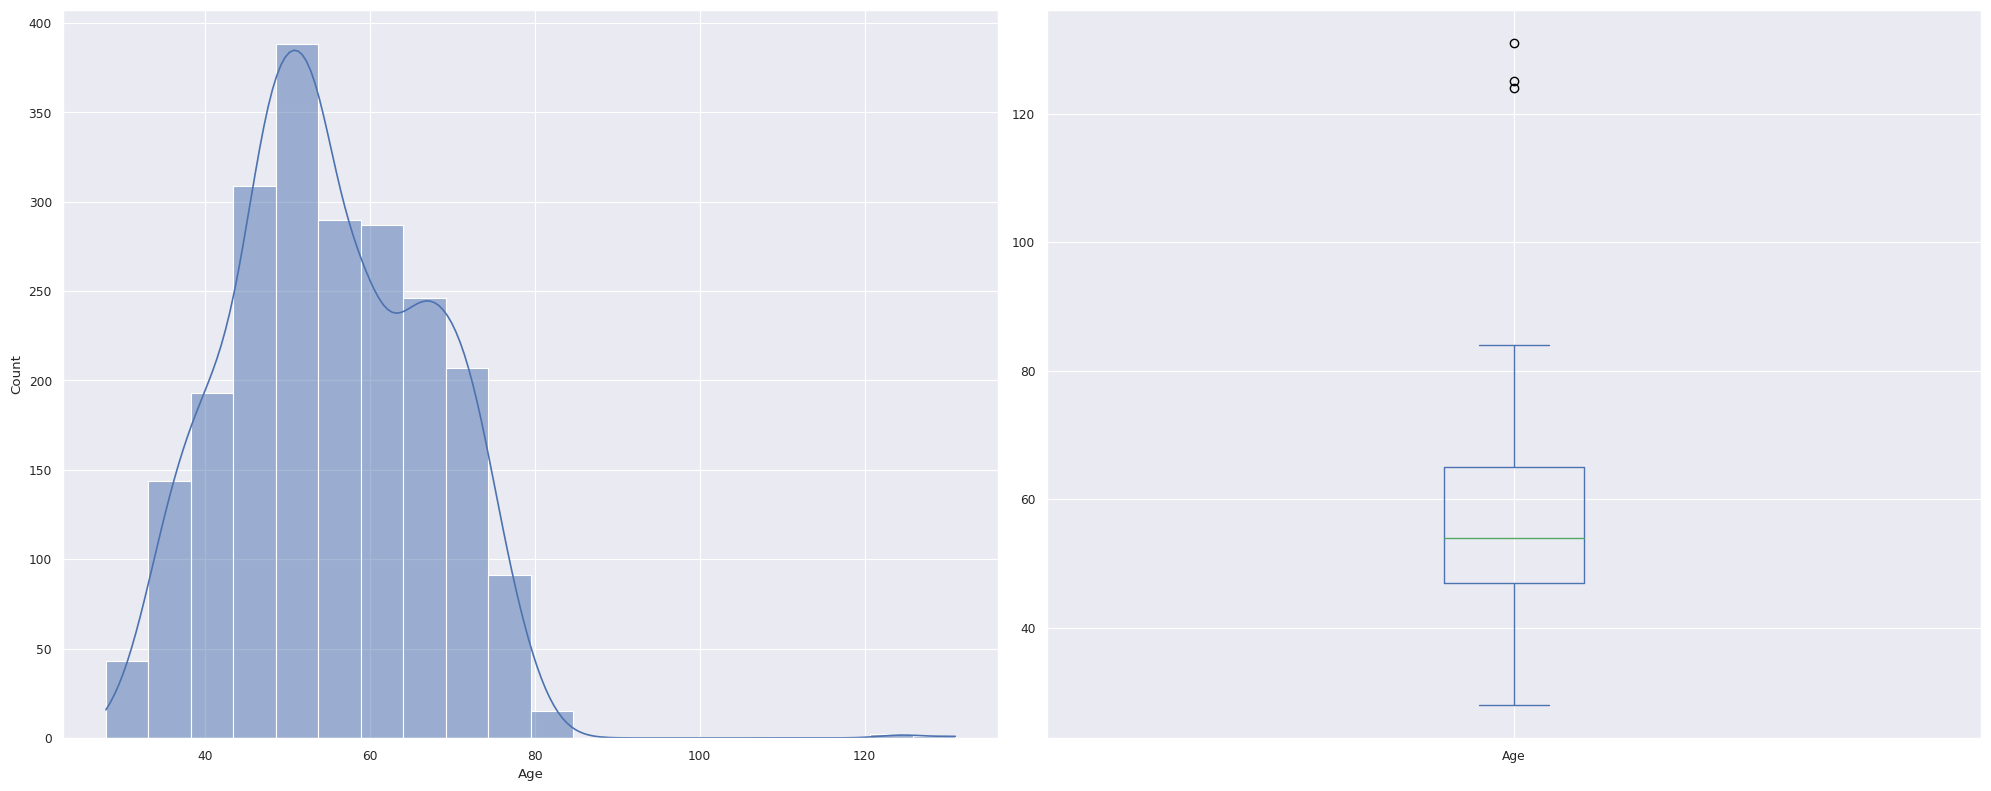

In [105]:
plt.subplot(1, 2, 1)
sns.histplot(df["Age"], kde=True, bins=20, palette=palette)
plt.subplot(1, 2, 2)
df["Age"].plot(kind="box");
plt.tight_layout()

In [106]:
df["Age"].describe()

count    2216.000000
mean       55.179603
std        11.985554
min        28.000000
25%        47.000000
50%        54.000000
75%        65.000000
max       131.000000
Name: Age, dtype: float64

The average customer is 55 yrs old with the youngest being 28 yrs old.
The oldest is 131 yrs old which is an outlier.

In [107]:
# Customers older than 100 yrs old with selected attributes
df_filtered = df[df["Age"] > 100][["Age","Income", "Education", "Marital_Status", "Prev_Responses", "Response", "Amount_Spent"]]
print(df_filtered.head())

     Age   Income      Education Marital_Status  Prev_Responses  Response  \
181  124  36640.0  Undergraduate         Single               0         0   
228  131  60182.0  Undergraduate        Married               0         0   
326  125  83532.0   Postgraduate         Single               1         0   

     Amount_Spent  
181            57  
228            21  
326          1202  


In [108]:
# Remove outliers in the "Age" column
df = df.loc[df["Age"] < 100]
df.shape

(2213, 24)

### **Income**

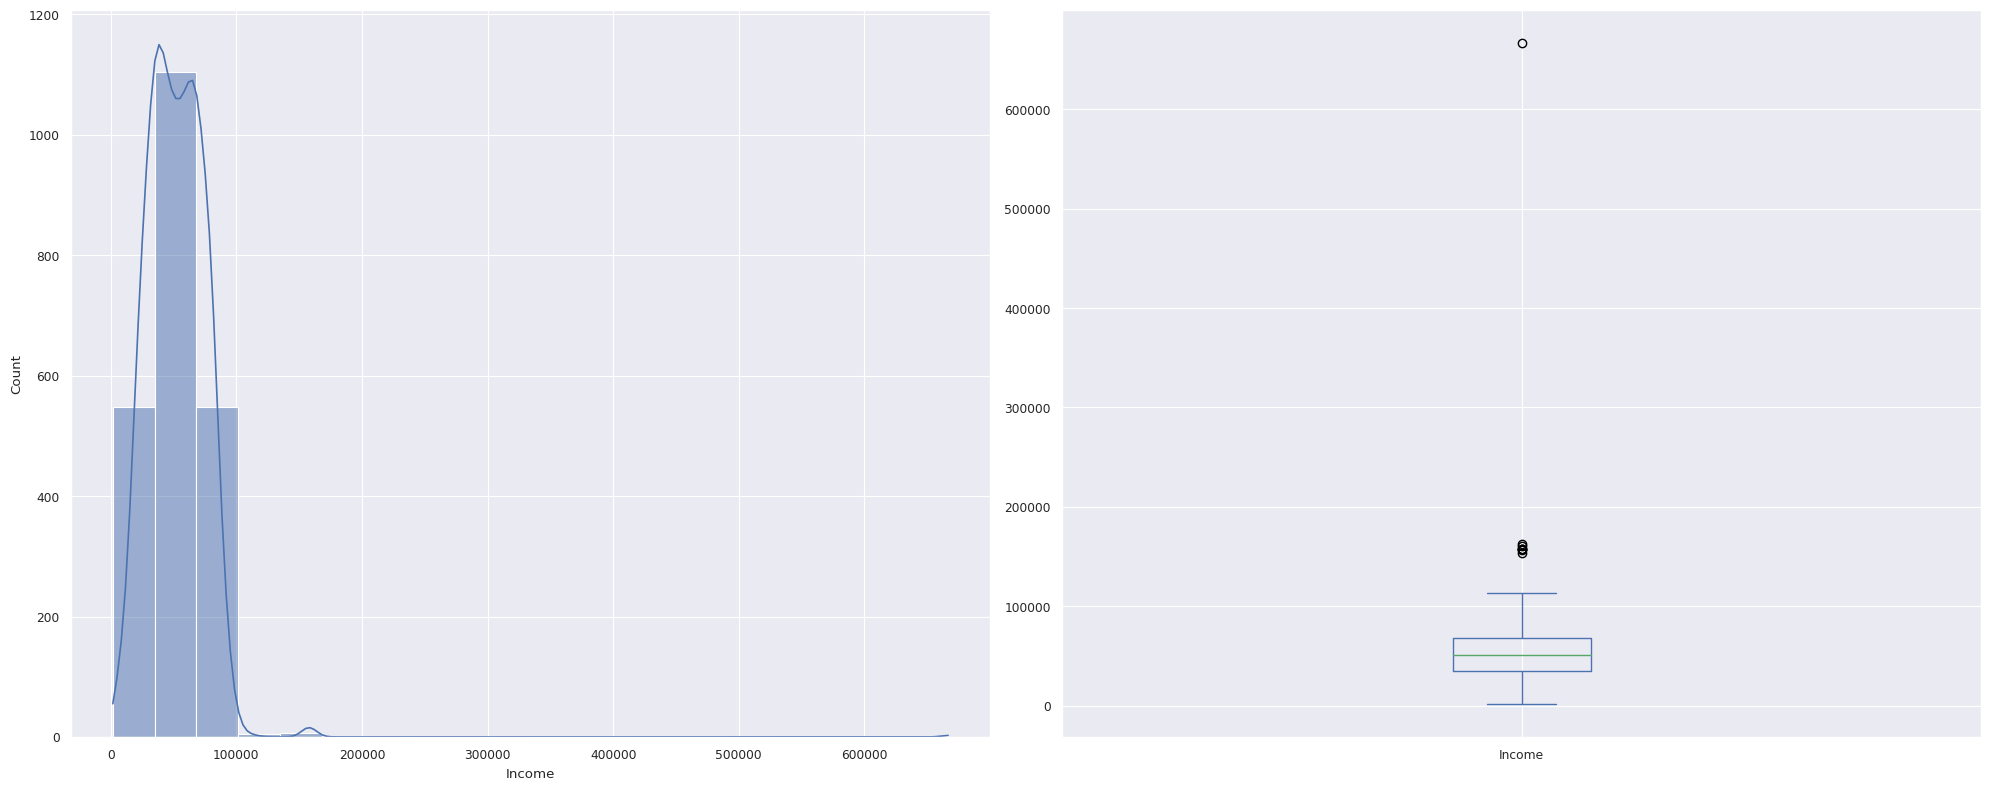

In [109]:
plt.subplot(1, 2, 1)
sns.histplot(df["Income"],kde=True, bins=20, palette=palette)
plt.subplot(1, 2, 2)
df["Income"].plot(kind="box");
plt.tight_layout()

In [110]:
# Customers with income > 100000 with selected columns

df_filtered = df[df["Income"] > 100000][["Age","Income", "Education", "Marital_Status", "Prev_Responses", "Response", "Amount_Spent"]]
print(df_filtered)

      Age    Income     Education Marital_Status  Prev_Responses  Response  \
115    41  101970.0      Graduate        Married               3         1   
153    51  157243.0  Postgraduate        Married               0         0   
192    47  102160.0  Postgraduate         Single               3         1   
241    50  102692.0      Graduate         Single               4         1   
604    48  162397.0  Postgraduate         Single               0         0   
633    54  105471.0      Graduate         Single               2         1   
642    49  153924.0      Graduate         Single               0         0   
674    42  160803.0  Postgraduate        Married               0         0   
1287   53  157733.0  Postgraduate         Single               0         0   
1636   47  157146.0      Graduate         Single               0         0   
1881   79  113734.0  Postgraduate        Married               0         0   
2109   75  156924.0  Postgraduate        Married               0

The customer who earns 666,666 does not spend much and has not responded positively to any of the campaigns

In [111]:
# Drop row with 666,666 income

df = df.drop(df[df["Income"] == 666666].index)

### **Total amount spent**

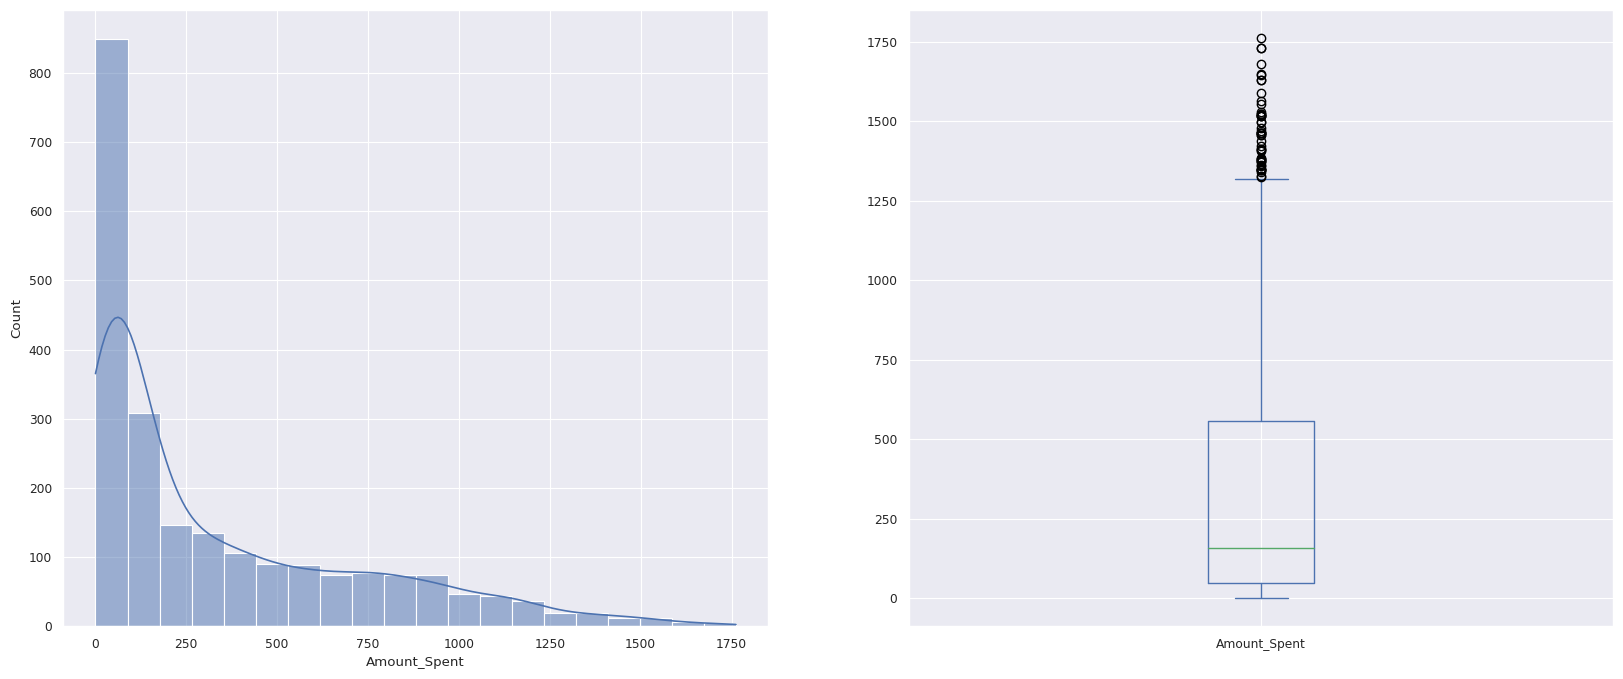

In [112]:
plt.subplot(1, 2, 1)
sns.histplot(df["Amount_Spent"],kde=True,bins=20, palette=palette)
plt.subplot(1, 2, 2)
df["Amount_Spent"].plot(kind="box");

In [113]:
df["Amount_Spent"].describe()

count    2212.000000
mean      339.629295
std       380.157849
min         1.000000
25%        47.000000
50%       158.000000
75%       557.000000
max      1762.000000
Name: Amount_Spent, dtype: float64

### **Number of children**


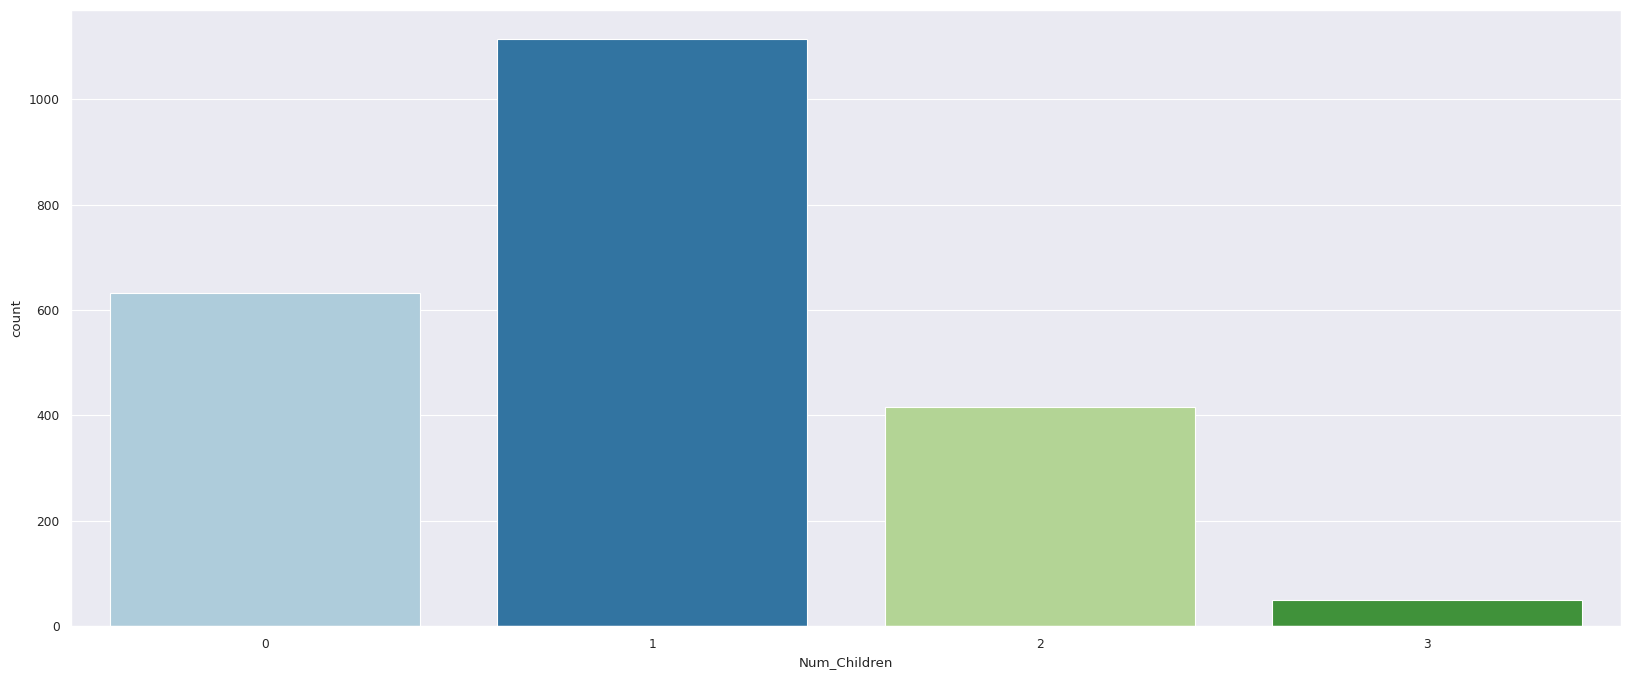

In [114]:
sns.countplot(x="Num_Children", data=df, palette=palette);

In [115]:
# Percentage of customers with at least one child

with_children = (df["Num_Children"] > 0).mean() * 100
print(f"Percentage of customers with at least one child: {with_children:.2f}%")

Percentage of customers with at least one child: 71.43%


Most of the customers are parents.

### **Marital Status**

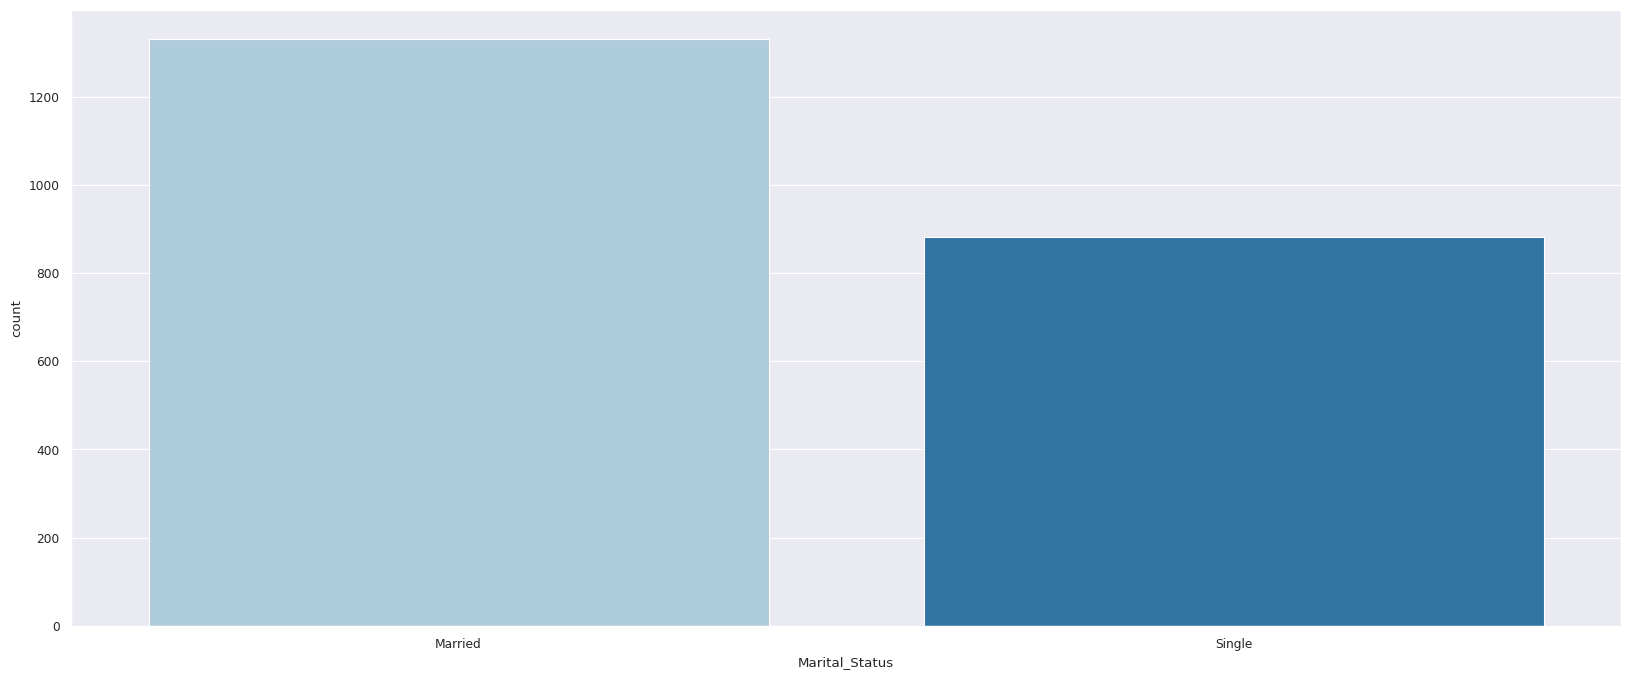

In [116]:
sns.countplot(x="Marital_Status", data=df, palette=palette);

In [117]:
married_percentage = df[df["Marital_Status"] == "Married"].shape[0] / df.shape[0] * 100
print(f"Percentage of married customers: {married_percentage:.2f}%")

Percentage of married customers: 60.13%


### **Education**

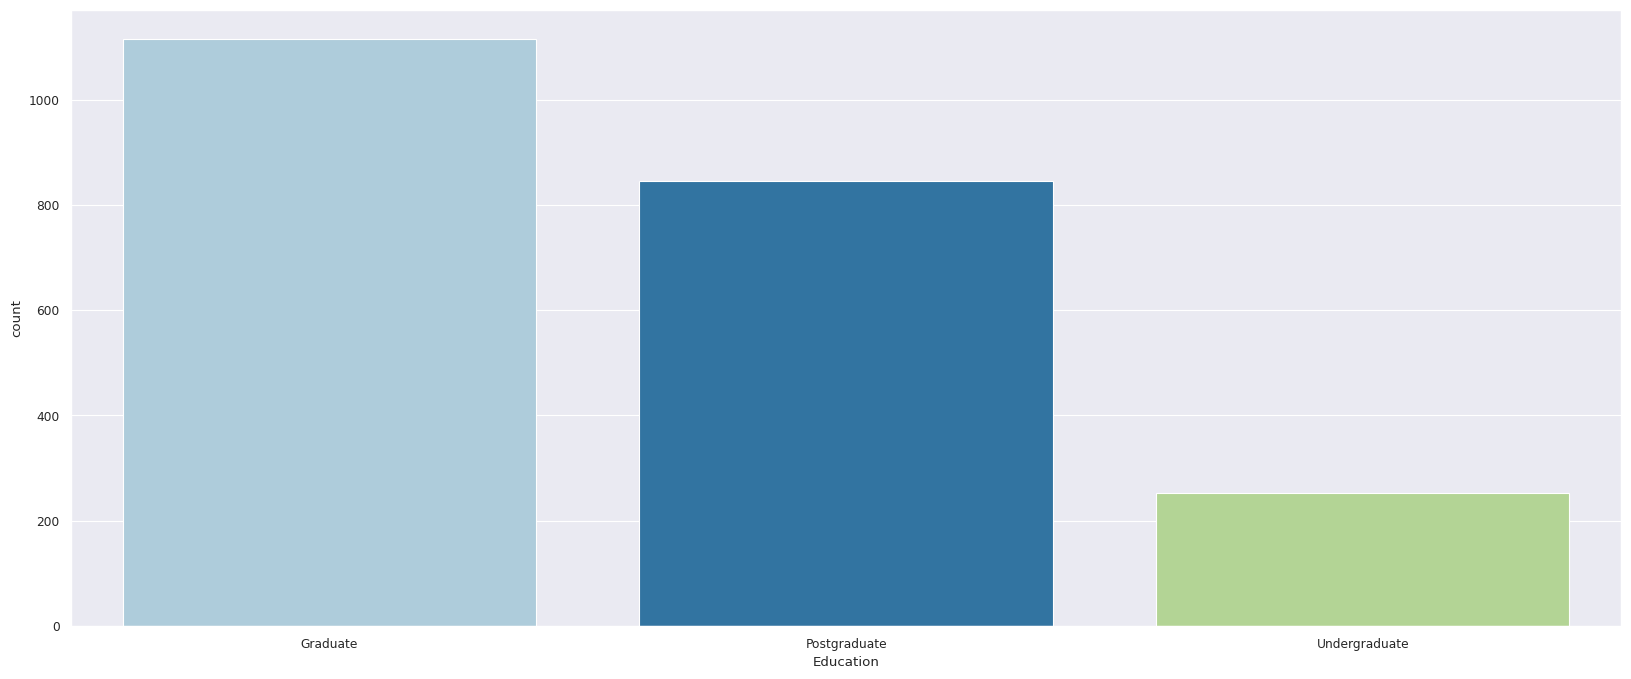

In [118]:
sns.countplot(x="Education", data=df, palette=palette);

Most of the customers have higher eduction

### **Complain Rate**

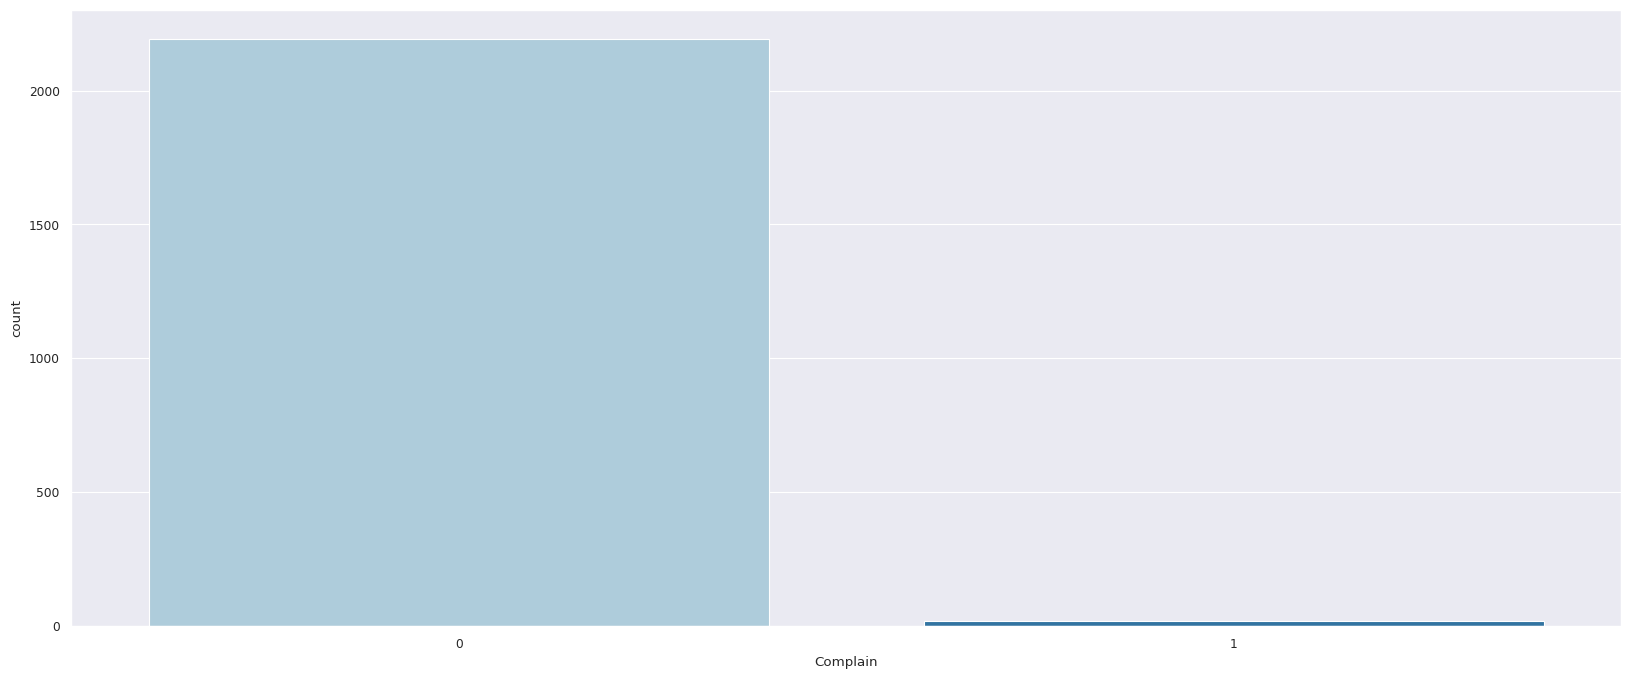

In [119]:
sns.countplot(x="Complain", data=df, palette=palette);

In [120]:
complained_percentage = df[df["Complain"] == 1].shape[0] / df.shape[0] * 100
print(f"Percentage of Customers who have complained before: {complained_percentage:.2f}%")

Percentage of Customers who have complained before: 0.90%


### **Responses**

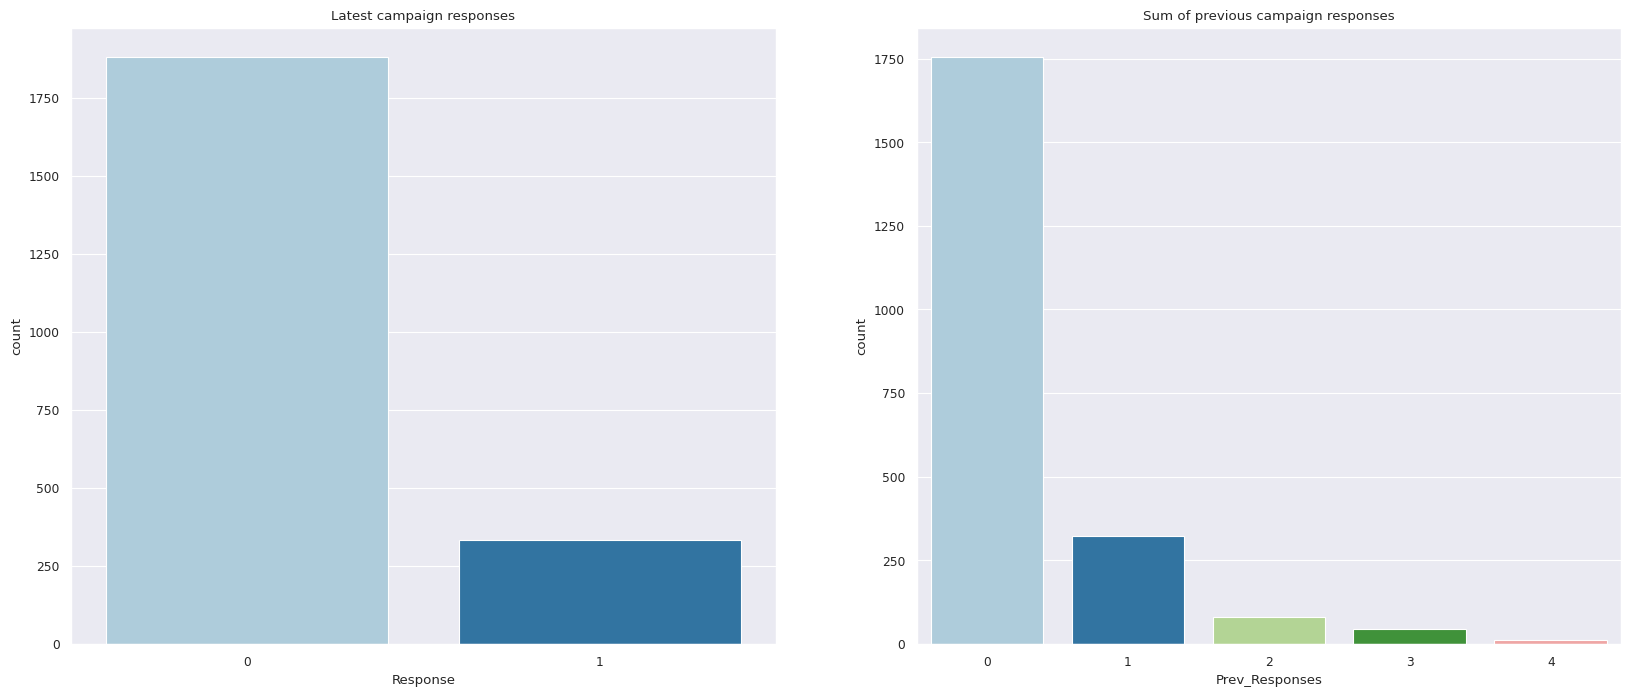

In [121]:
fig, axes = plt.subplots(1, 2, figsize=(20, 8))

# Create a countplot of "Response"
sns.countplot(x="Response", data=df, palette=palette, ax=axes[0])
axes[0].set_title("Latest campaign responses")

# Create a countplot of Prev_Responses on the second subplot
sns.countplot(x="Prev_Responses", data=df, palette=palette, ax=axes[1])
axes[1].set_title("Sum of previous campaign responses");

In [122]:
df[["Response", "Prev_Responses"]].value_counts()

Response  Prev_Responses
0         0                 1608
          1                  222
1         0                  146
          1                  100
          2                   42
0         2                   39
1         3                   35
          4                   10
0         3                    9
          4                    1
Name: count, dtype: int64

In [123]:
# Calculate percentage of customers who responded to the latest campaign "Response" and percentage of people who responded to at least one previous campaign

response_rate = (df["Response"] == 1).mean() * 100
prev_response_rate = (df["Prev_Responses"] > 0).mean() * 100

print(f"Percentage of customers who responded to the latest campaign: {response_rate:.2f}%")
print(f"Percentage of customers who responded to at least one previous campaign: {prev_response_rate:.2f}%")

Percentage of customers who responded to the latest campaign: 15.05%
Percentage of customers who responded to at least one previous campaign: 20.71%


In [124]:
Total_Responses = df["Prev_Responses"] + df["Response"]
Total_Responses.value_counts()

0    1608
1     368
2     139
3      51
4      36
5      10
Name: count, dtype: int64

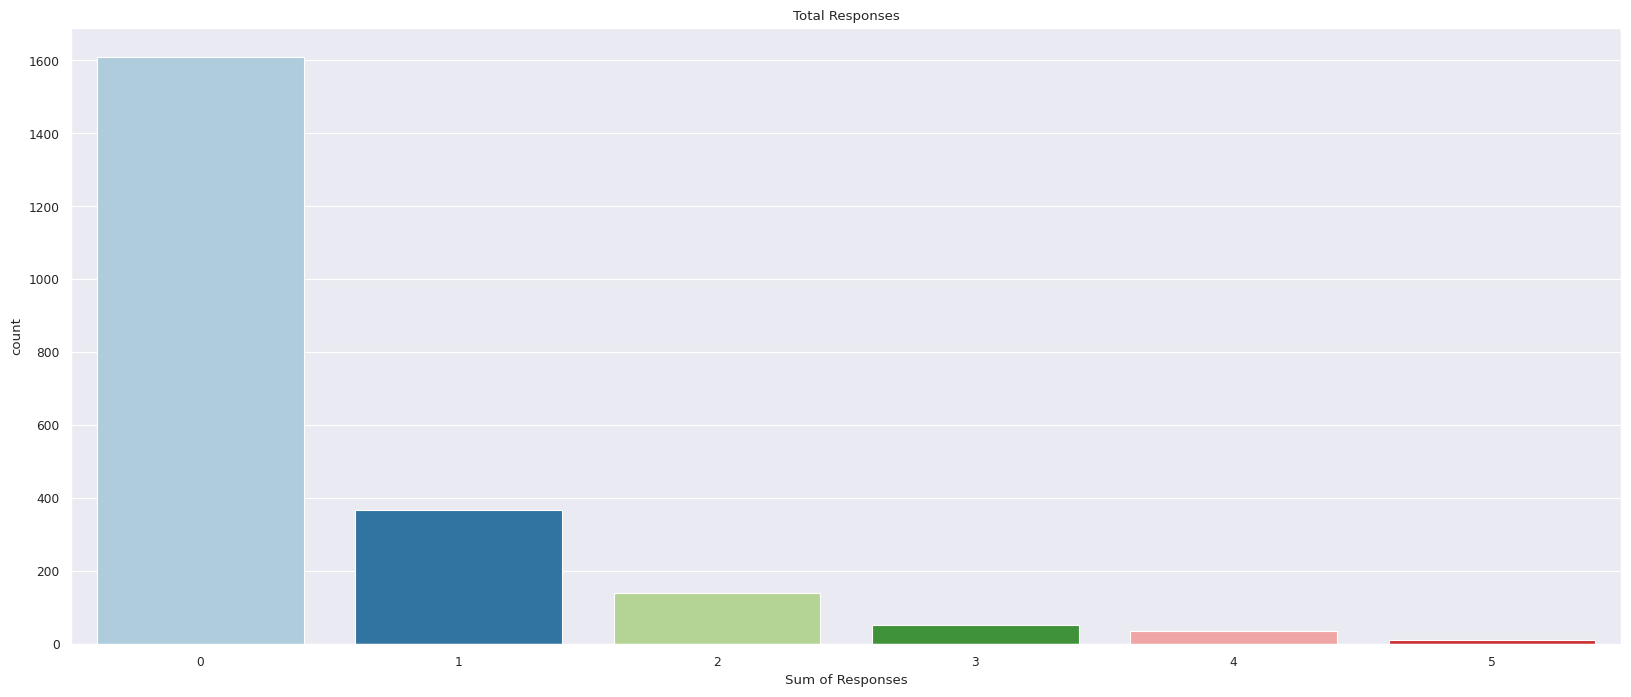

In [125]:
# Sum of responses
sns.countplot(x=Total_Responses, data=df, palette=palette)
plt.xlabel("Sum of Responses")
plt.title("Total Responses");

In [126]:
all_responses_rate = (Total_Responses > 0).mean() * 100
print(f"Percentage of customers who responded to at least one of the campaigns : {all_responses_rate:.2f}%")

Percentage of customers who responded to at least one of the campaigns : 27.31%


No customer responded positively to all the campaigns

Only 10 customers accepted 5 campaigns

### **Response Rate by Marital Status**

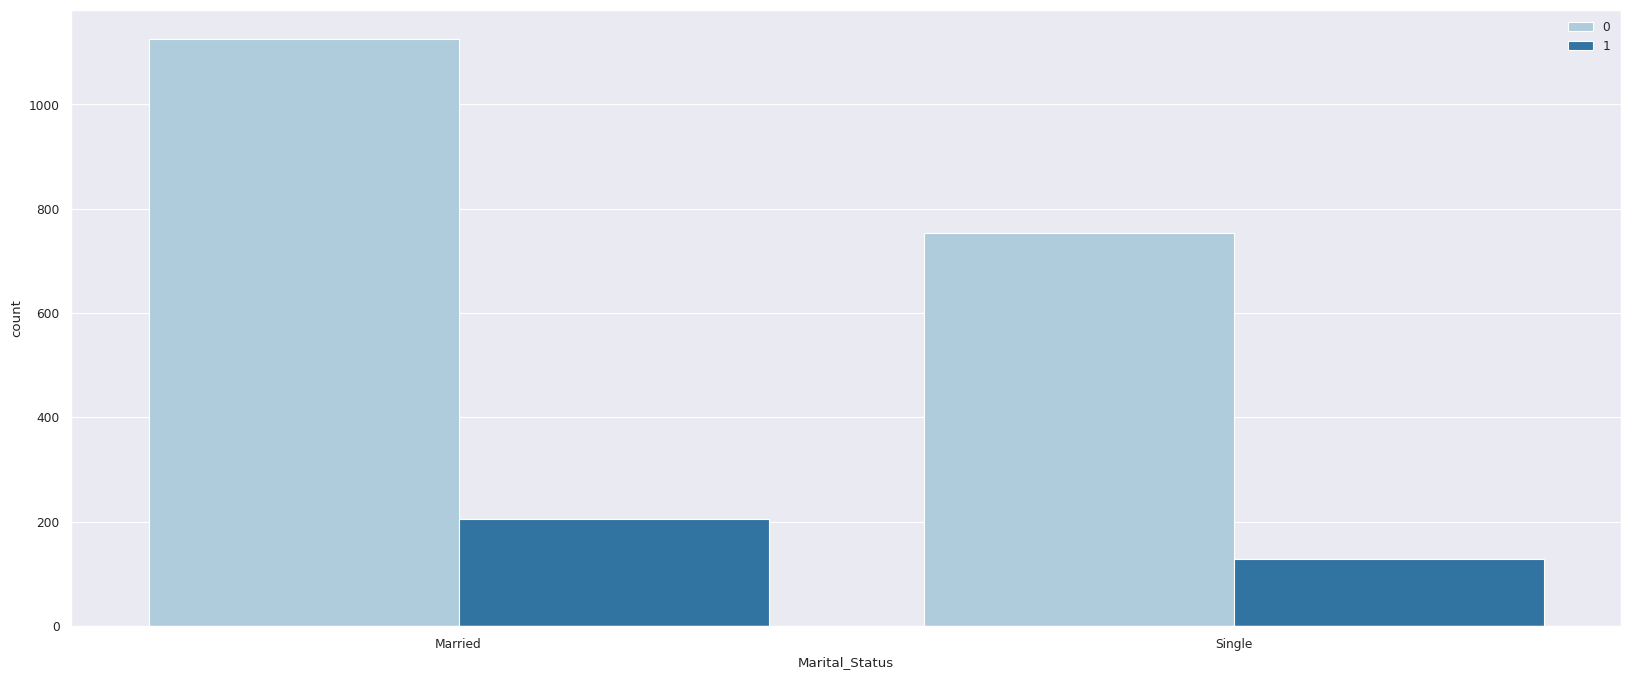

In [127]:
sns.countplot(data=df, x="Marital_Status", hue="Response", palette=palette)
plt.legend(frameon=False);

In [128]:
# Percentage of married and sigle customers who reponded to the last campaign

married_response_rate = df[df["Marital_Status"] == "Married"]["Response"].mean() * 100
single_response_rate = df[df["Marital_Status"] == "Single"]["Response"].mean() * 100

print(f"Percentage of married customers who responded: {married_response_rate:.1f}%")
print(f"Percentage of single customers who responded: {single_response_rate:.1f}%")

Percentage of married customers who responded: 15.4%
Percentage of single customers who responded: 14.5%


In [129]:
pd.crosstab(df["Marital_Status"], df["Response"])

Response,0,1
Marital_Status,,
Married,1125,205
Single,754,128


The married customers have a higher response rate than the single customers


### **Response Rate by Education Level**

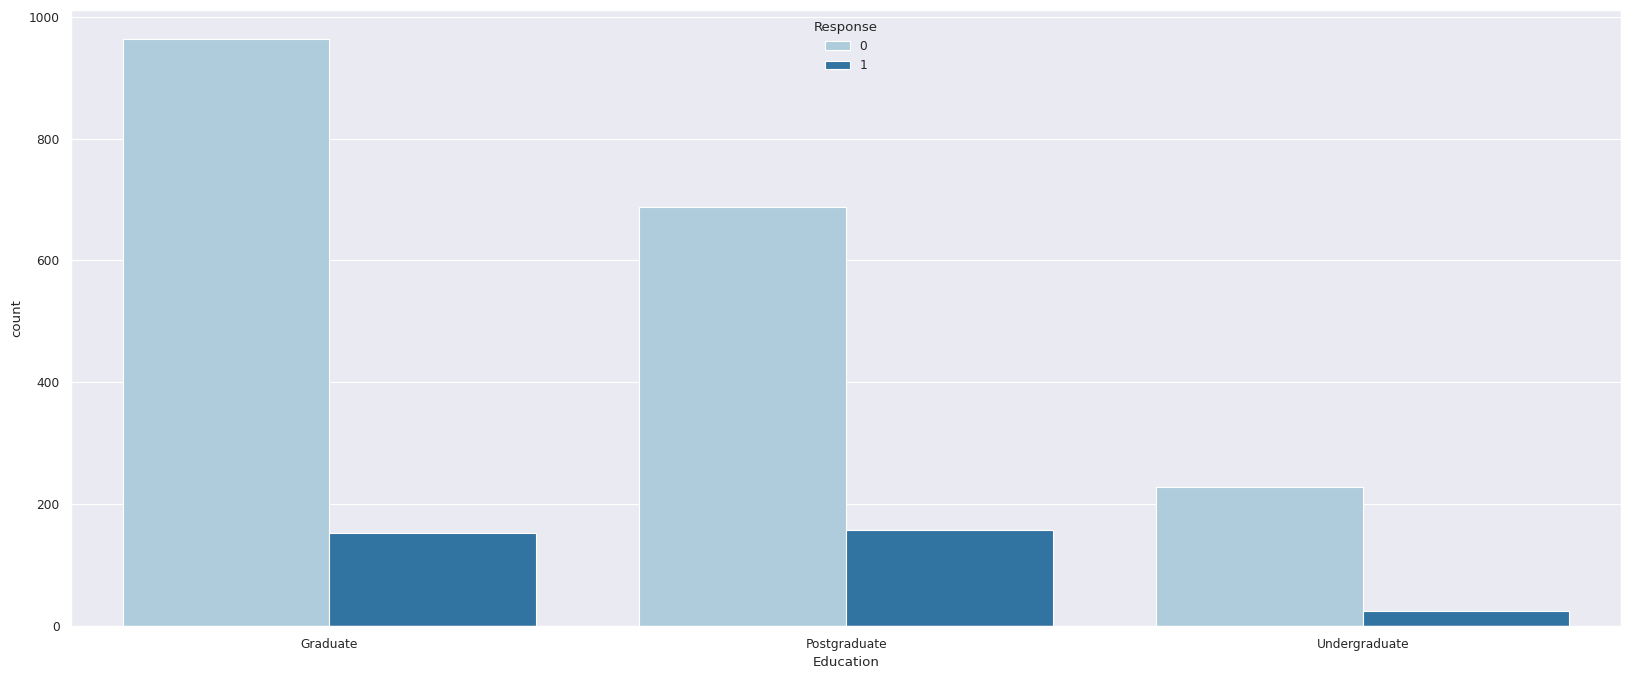

In [130]:
sns.countplot(data=df, x="Education", hue="Response", palette=palette)
plt.legend(frameon=False, loc="upper center", title = "Response");

In [131]:
undergraduate_response_rate = df[df["Education"] == "Undergraduate"]["Response"].mean() * 100
graduate_response_rate = df[df["Education"] == "Graduate"]["Response"].mean() * 100
postgraduate_response_rate = df[df["Education"] == "Postgraduate"]["Response"].mean() * 100

print(f"Percentage of undergraduate customers who responded: {undergraduate_response_rate:.1f}%")
print(f"Percentage of graduate customers who responded: {graduate_response_rate:.1f}%")
print(f"Percentage of postgraduate customers who responded: {postgraduate_response_rate:.1f}%")

Percentage of undergraduate customers who responded: 9.5%
Percentage of graduate customers who responded: 13.6%
Percentage of postgraduate customers who responded: 18.6%


In [132]:
pd.crosstab(df["Education"], df["Response"])

Response,0,1
Education,,
Graduate,963,152
Postgraduate,688,157
Undergraduate,228,24


### **Response Rate Vs Education Level amongst the Married and Single customers**

In [133]:
df_single = df[df['Marital_Status'] == 'Single']
df_married = df[df['Marital_Status'] == 'Married']

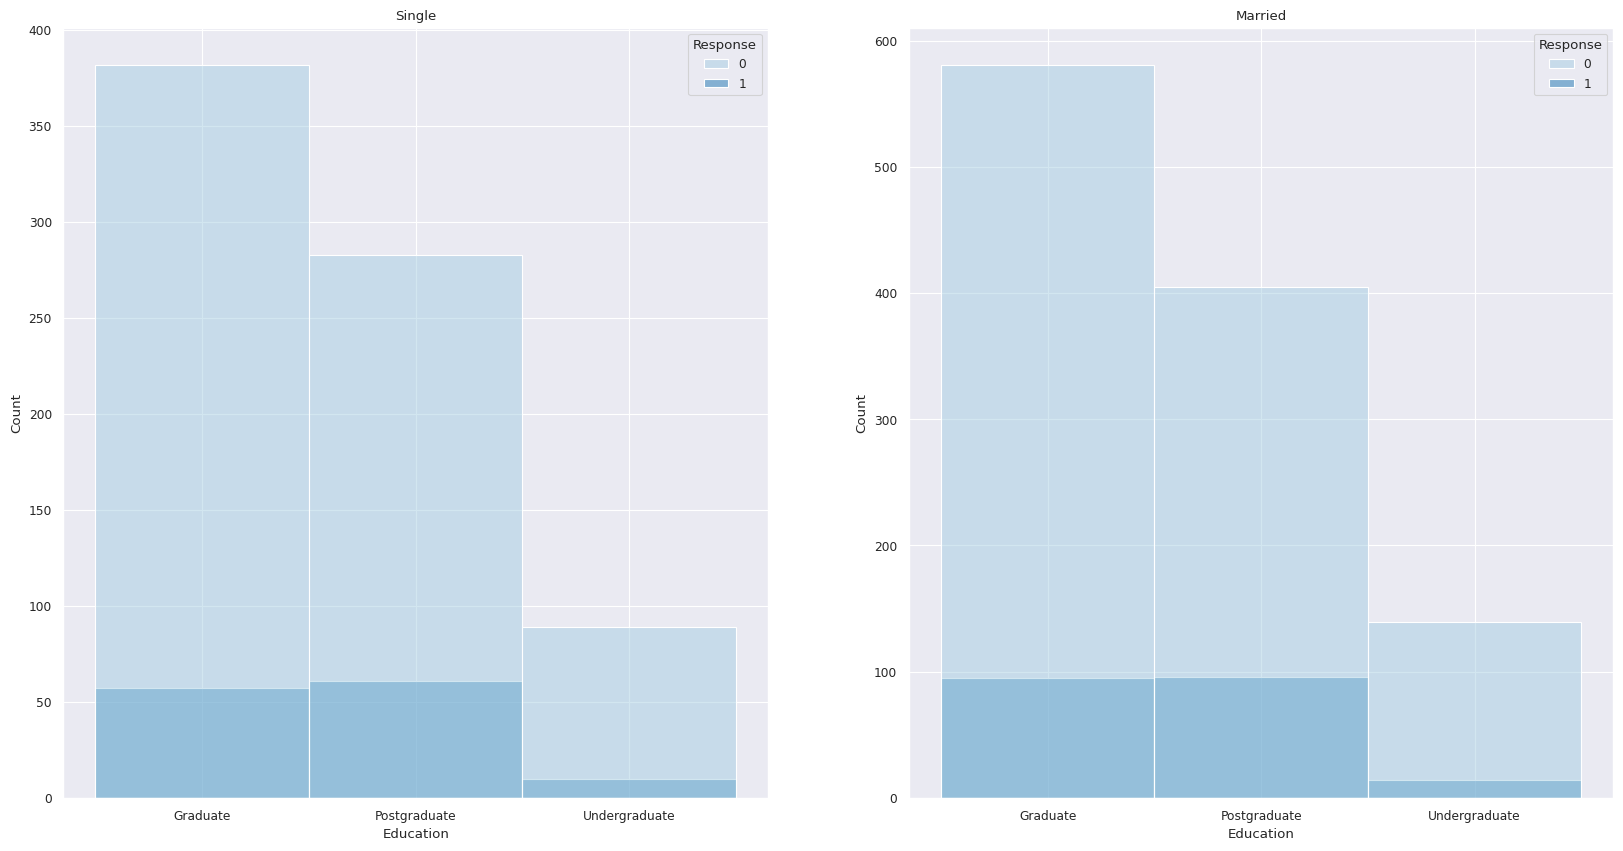

In [134]:
fig, axs = plt.subplots(1, 2, figsize=(20, 10))

sns.histplot(x="Education", hue="Response", data=df_single, palette=palette, ax=axs[0])
axs[0].set_title("Single")

sns.histplot(x="Education", hue="Response", data=df_married, palette=palette, ax=axs[1])
axs[1].set_title("Married");


In [135]:
df[["Marital_Status", "Education"]].value_counts()

Marital_Status  Education    
Married         Graduate         676
                Postgraduate     501
Single          Graduate         439
                Postgraduate     344
Married         Undergraduate    153
Single          Undergraduate     99
Name: count, dtype: int64

### **Income distribution by Marital Status and Education**

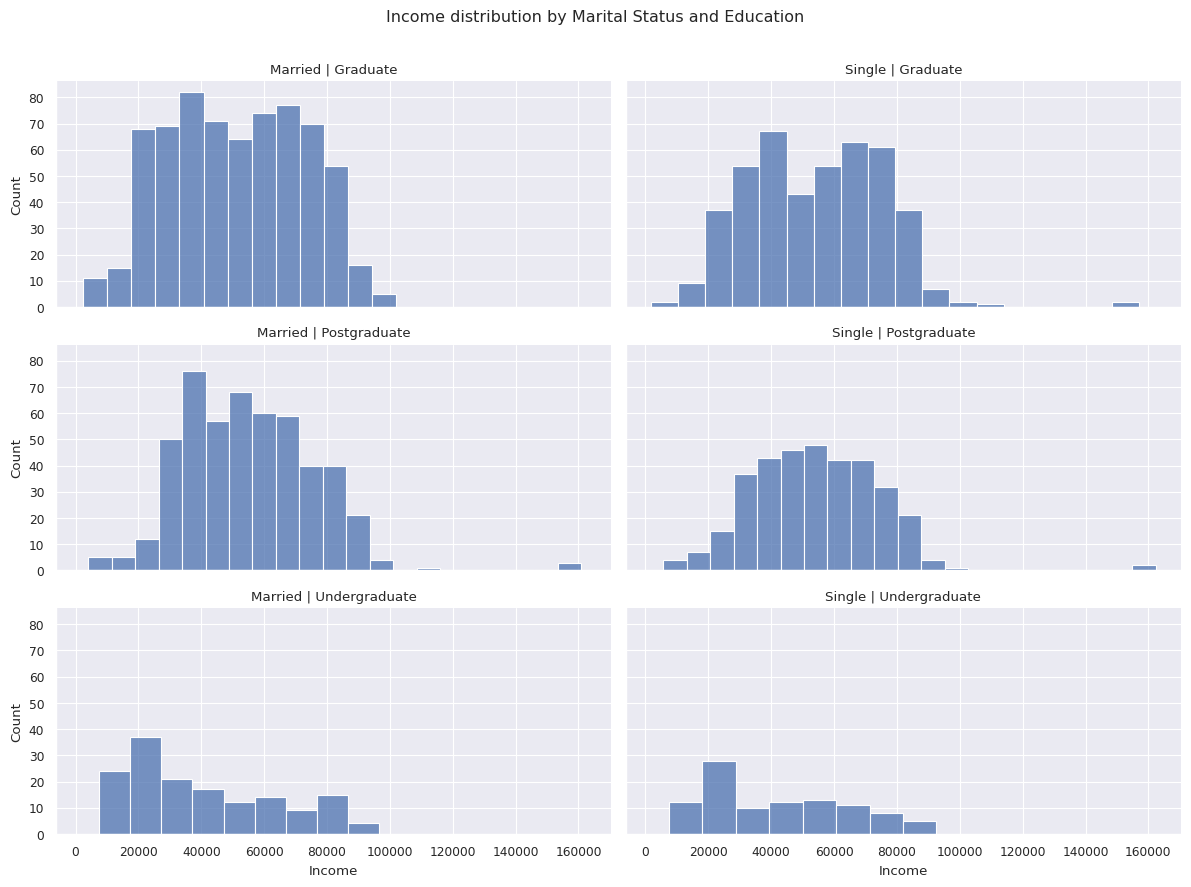

In [136]:
grid = sns.FacetGrid(df, col="Marital_Status", row="Education", height=3, aspect=2.0)
grid.map(sns.histplot, "Income", palette=palette)
grid.set_axis_labels("Income", "Count")
grid.set_titles("{col_name} | {row_name}")
plt.subplots_adjust(top=0.9)
grid.fig.suptitle("Income distribution by Marital Status and Education");

### **Relationship between Age, Income, Spending, and Children Count Grouped by Response**

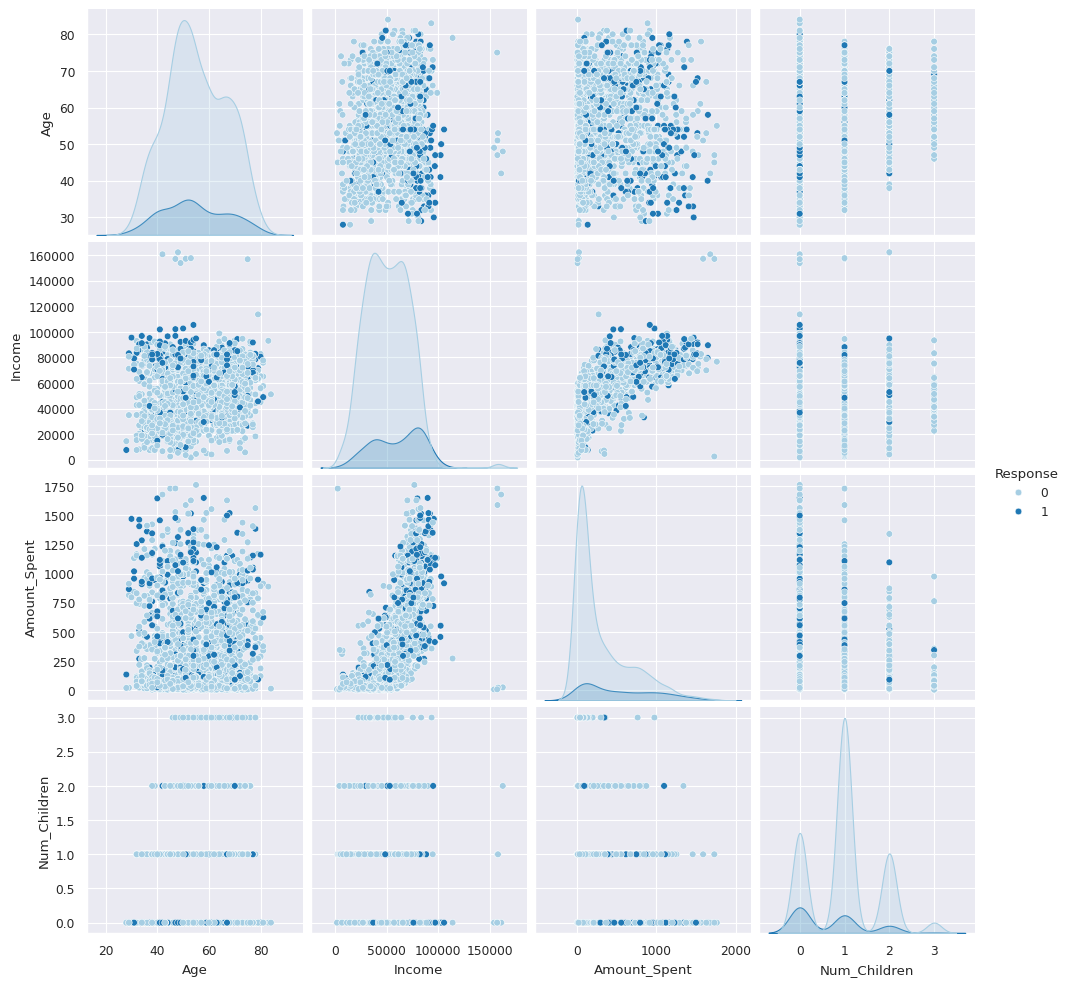

In [137]:
sns.pairplot(df, vars=["Age", "Income", "Amount_Spent", "Num_Children"], hue="Response", palette=palette);

In [ ]:
# one hot encode

cat_cols = ["Education", "Marital_Status"]
df = pd.get_dummies(df, columns=cat_cols, drop_first=True)

**Correlation**

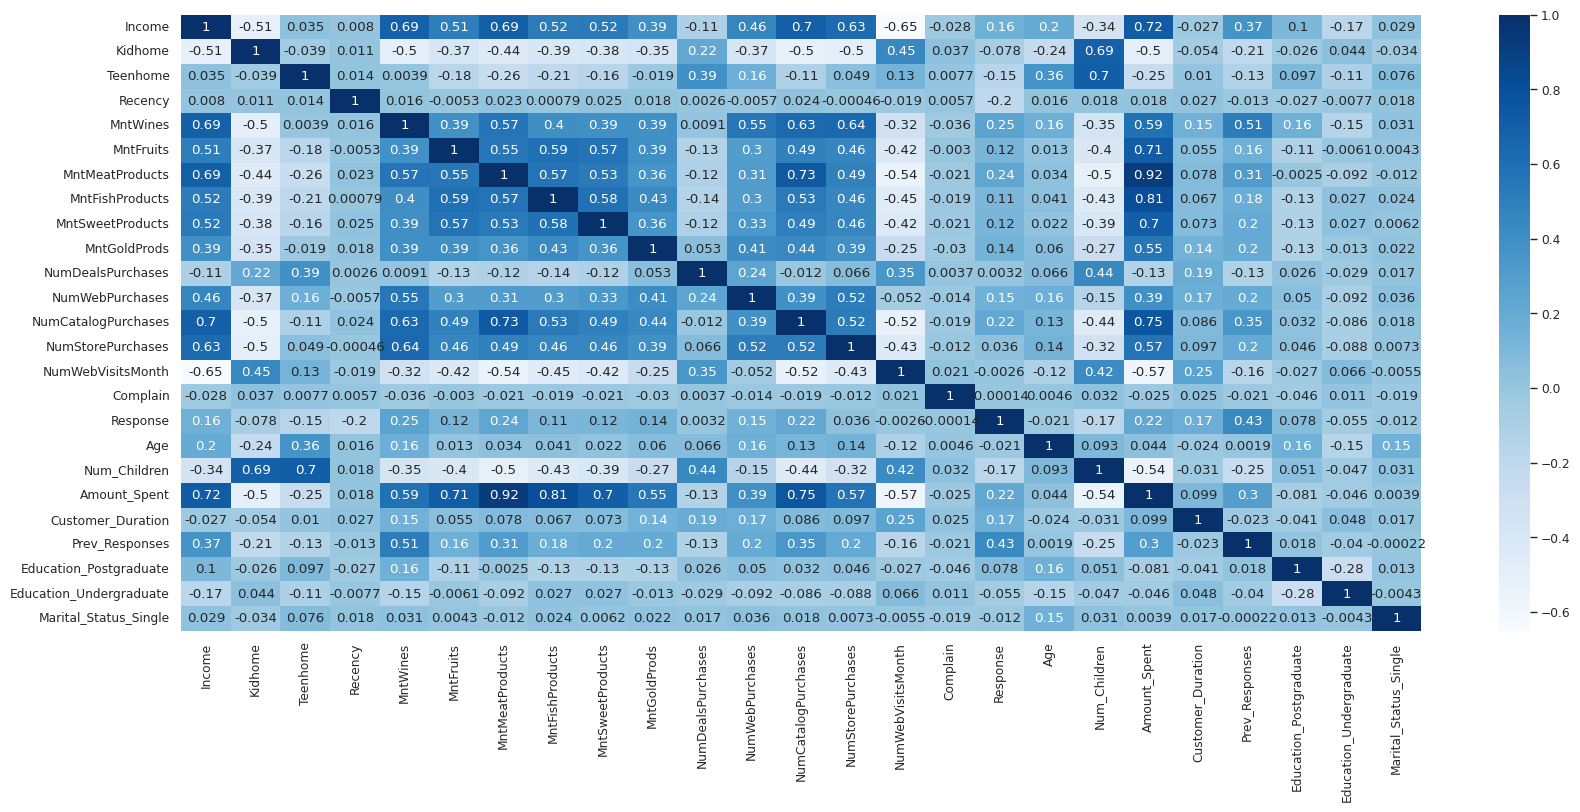

In [141]:
corr = df.corr()
sns.heatmap(corr, annot=True, cmap="Blues");